<a href="https://colab.research.google.com/github/melissadebie/TM10007_PROJECT/blob/master/final_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template
Janne Luijten, Mathilde Scholtes, Imane Ihaddouchen and Melissa de Bie

In [0]:
# Run this to use from colab environment
!pip install missingpy -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

     |████████████████████████████████| 51kB 1.7MB/s 


## Data loading

In [0]:
# Data loading function
from hn.load_data import load_data

# General packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import sklearn
import pandas as pd
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection 
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from time import time

# Imputing
from missingpy import KNNImputer
 
# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF

# Cross-validation 
from sklearn.model_selection import StratifiedKFold, KFold



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and print data

In [0]:
# Load Data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

y = data['label']

# Binarize the data for tumor stages
y_bin = []
for i in y:
  if i == 'T12':
    i=0
    y_bin.append(i)
  else:
      i=1
      y_bin.append(i)
y_bin = np.transpose(y_bin)


The number of samples: 113
The number of columns: 160


## Data Cleaning - Removing outliers

In [0]:
# Settings to view more of the df
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

# Drop labels-column to apply outlier removal
data_no_labels = data.copy()
data_no_labels.drop(columns=['label'], axis=1, inplace=True)

# Turn outliers into NaN (below 1% and above 99%)
for column in data_no_labels.columns:
  data_no_labels.loc[(data_no_labels[column] <= data_no_labels[column].quantile(0.01)) | (data_no_labels[column] >= data_no_labels[column].quantile(0.99)), column] = np.nan
data_no_labels_no_outliers = data_no_labels.copy()

# Add labels-column to df without outliers
data_no_labels_no_outliers['label'] = y
data_no_outliers = data_no_labels_no_outliers.copy()

## Cleaning data - Removing missing data

In [0]:
# Clearing of missing data
number_of_columns = len(data.columns)
number_of_rows = len(data.index)

# Set threshold for removing columns (10% missing data)
threshold_columns = 0.1*number_of_rows

# Replace all missing values (0.0) with NaN
data_nans = data_no_outliers.replace(to_replace=0.0, value=np.nan)

# Loop over every column and remove if too many NaN values
for column in data_nans.columns:
    sum_nans = data_nans[column].isna().sum()
    if sum_nans >= threshold_columns:
        del data_nans[column]

# Set threshold for removing rows (30% missing data)
number_of_columns_after_column_del = len(data_nans.columns)
threshold_rows = 0.3*number_of_columns_after_column_del

# Loop over every row and remove if too many NaN values
for index, row in data_nans.iterrows():
    sum_nans = row.isna().sum()
    if sum_nans >= threshold_rows:
        data_nans.drop(index, inplace=True)

# Calculate remaining NaN values (total, per column, per row) and print
de_som = data_nans.isnull().sum().sum()

nans_per_column = data_nans.isnull().sum(axis = 0)
nans_per_column_nonzero = nans_per_column[nans_per_column>0]

nans_per_row = data_nans.isnull().sum(axis = 1)
nans_per_row_nonzero = nans_per_row[nans_per_row>0]

data_nans_no_labels = data_nans.copy()
data_nans_no_labels.drop(columns=['label'], axis=1, inplace=True)

## Data imputation
Imputating data on NaN locations

In [0]:
# Save the indices of rows and columns
row_indices = data_nans_no_labels.index.tolist()
column_indices = data_nans_no_labels.columns.tolist()

# MissingPy KNN imputer
def imputed_data(data_nans_no_labels): 
  kNN_imputer = KNNImputer(missing_values=np.nan, weights='distance')
  kNN_imputer = kNN_imputer.fit(data_nans_no_labels)
  data_kNN_imp_array = kNN_imputer.transform(data_nans_no_labels)
  data_kNN_imp_no_labels = pd.DataFrame(data=data_kNN_imp_array, index=row_indices, columns=column_indices)
  return data_kNN_imp_no_labels

data_kNN_imp_no_labels = imputed_data(data_nans_no_labels)

# Adding labels back to df's
data_kNN_imp_no_labels['label'] = y
data_kNN_imp = data_kNN_imp_no_labels.copy()

data = data_kNN_imp
y = y_bin

# Data without label
data_without_label = data.drop(columns=['label'])

/usr/local/lib/python3.6/dist-packages/missingpy/pairwise_external.py:135: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=warn_on_dtype, estimator=estimator)
/usr/local/lib/python3.6/dist-packages/missingpy/pairwise_external.py:138: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=warn_on_dtype, estimator=estimator)
/usr/local/lib/python3.6/dist-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


## Scale data
Scale the data with different scalers

In [0]:
# This function scales the data
def scaled_data(X_train_no_label, X_test_no_label):
  # Saving indices of rows and columns
  train_row_indices = X_train_no_label.index.tolist()
  train_column_indices = X_train_no_label.columns.tolist()
  test_row_indices = X_test_no_label.index.tolist()
  test_column_indices = X_test_no_label.columns.tolist()

  # Scaled data as array (without column 'label')
  minmax_scaler = MinMaxScaler()
  Xtr_r_array = minmax_scaler.fit_transform(X_train_no_label)
  Xte_r_array = minmax_scaler.transform(X_test_no_label)

  # Scaled data as dataframe (without column 'label')
  Xtr_r = pd.DataFrame(data=Xtr_r_array, index=train_row_indices, columns=train_column_indices)
  Xte_r = pd.DataFrame(data=Xte_r_array, index=test_row_indices, columns=test_column_indices)
  # Scaled data as dataframe (with column 'label')
  Xtr_r_labels = Xtr_r.copy()
  Xte_r_labels = Xte_r.copy()

  return Xtr_r, Xte_r, Xtr_r_array, Xte_r_array 

### PCA

In [0]:
# This function trains and plots the Principal Component Analysis
def pca(Xtr_r, Xte_r, y_train, y_test):
  pca=PCA(n_components=2) 
  pca.fit(Xtr_r) 
  X_pca=pca.transform(Xtr_r) 

  # Variance ratio
  ex_variance=np.var(X_pca,axis=0)
  ex_variance_ratio = ex_variance/np.sum(ex_variance)
  # print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)) 

  Xax=X_pca[:,0]
  Yax=X_pca[:,1]

  # Making plot: 
 
  # cdict={0:'red',1:'green'}
  # label={0:'T12',1:'T34'}
  # marker={0:'*',1:'o'}
  # alpha={0:.3, 1:.5}
 
  # fig,ax=plt.subplots(figsize=(7,5))
  # fig.patch.set_facecolor('white')

  # for l in np.unique(y_train):
    # ix=np.where(y_train==l)
    # ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
              # label=label[l],marker=marker[l],alpha=alpha[l])
  
  # plt.xlabel("First Principal Component - {0:.3}%".format(pca.explained_variance_ratio_[0]*100),  fontsize=14)
  # plt.ylabel("Second Principal Component - {0:.3}%".format(pca.explained_variance_ratio_[1]*100), fontsize=14)
  # plt.legend()
  # plt.show()

  #Plot cumulative explained variance:
  
  pca = PCA().fit(Xtr_r)
  variance = np.cumsum(pca.explained_variance_ratio_)
  # plt.figure()
  # plt.figure(figsize=(5,5))
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.plot(variance)
  # plt.grid(b=None)
  # plt.xlabel('Number of Components')
  # plt.ylabel('Cumulative Explained Variance') # for each component
  # plt.title('Principal Component Analysis ')
  # plt.show()

  # Applying PCA to keep 97% of the variance
  n_components = np.where(variance>0.97)[0][0]
  pca = PCA(n_components=n_components)
  PrincipalComponents = pca.fit_transform(Xtr_r)

  # Transform data using PCA
  Xtr_pca = pca.transform(Xtr_r)
  Xte_pca = pca.transform(Xte_r)

  print(f'Selected amount of components by PCA:', Xtr_pca.shape)

  return Xtr_pca, Xte_pca

## Feature selection methods
Multiple feature selection methods will be applied and analyzed, and the performance is measured through the accuracy. The most suitable method, so the method with the best performance on the training set is used.

# Lasso Regression feature selection

In [0]:
# This function performs Lasso feature selection
def lasso2_featureselection(Xtr_r, y_train, Xte_r, y_test):
  selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
  selector.fit(Xtr_r, y_train)
  n_original = Xte_r.shape[1]
  Xtr_lasso = selector.transform(Xtr_r)
  Xte_lasso = selector.transform(Xte_r)
  n_selected = Xtr_lasso.shape[1]
  print('Selected amount of features by LASSO:', f"{n_selected} from {n_original}")

  # Fit the LDA on selected features
  clf = LDA()
  clf.fit(Xtr_lasso, y_train)
  y_score = clf.predict_proba(Xte_lasso)
  # plot_roc_curve(y_score, y_test)

  df_lasso_2_train=pd.DataFrame(Xtr_lasso)
  df_lasso_2_test=pd.DataFrame(Xte_lasso)
  return df_lasso_2_train, df_lasso_2_test

# Univariate Feature Selection

In [0]:
# This function performs univariate feature selection
def univariate_featureselection(Xtr_r, y_train, Xte_r, y_test):
  X_indices = np.arange(Xtr_r.shape[-1])

  # The best features are determined
  selector = SelectKBest(score_func=f_classif, k=20)
  selector.fit(Xtr_r, y_train)

  # Determine and print the new dataframes
  selector_train=selector.transform(Xtr_r)
  selector_test=selector.transform(Xte_r)
  (scores) = -np.log10(selector.pvalues_)
  scores /= scores.max()
  df_scores = pd.DataFrame(selector.scores_)
  df_scores = df_scores[(df_scores > 0.5).any(1)]
  df_columns = pd.DataFrame(X_train_no_label.columns)

  # Concat two dataframes for better visualization 
  feature_Scores = pd.concat([df_columns,df_scores],axis=1)
  feature_Scores.columns = ['Specs','Score']  #naming the dataframe columns

  df_univariate_train=pd.DataFrame(selector_train)
  df_univariate_test=pd.DataFrame(selector_test)
  print(f'Selected amount of features by univariate feature selection:', df_univariate_train.shape)
  
  return df_univariate_train, df_univariate_test

# Classifiers

SVM, RF, K-NN classifiers will be used








## Support Vector Machine classifier

In [0]:
# Function of SVM Classifier with best hyperparameters
auc_SVM = []
F1_SVM = []
precision_SVM = []
recall_SVM = []
acctr_SVM = []
accte_SVM = []
def svm_classifier(Xtr_pca, Xte_pca, y_train, y_test, auc_SVM, F1_SVM, precision_SVM, recall_SVM, acctr_SVM, accte_SVM,):
  
  # Hyperparameters that we want to tune 
  C = [0.01, 0.5, 1.0]
  kernel = ['linear', 'rbf', 'poly']
  degree = list(range(5))

  # Convert to dictionary
  hyperparameters = dict(C=C, kernel=kernel, degree=degree) 
                           
  # SVC 
  svc = SVC(probability=True)

  # Use RandomizedSearch
  clf = RandomizedSearchCV(svc, hyperparameters, cv=10)

  # Fit the model
  best_model_svm = clf.fit(Xtr_pca, y_train)

  # Determine best parameters
  best_C = best_model_svm.best_estimator_.get_params()['C']
  best_kernel = best_model_svm.best_estimator_.get_params()['kernel']
  best_degree = best_model_svm.best_estimator_.get_params()['degree']

  # The classification with the best hyperparameters starts here
  clf_svm = SVC(C=best_C, kernel=best_kernel, degree=best_degree, probability=True)
  clf_svm.fit(Xtr_pca,y_train)
  train_score_svm = clf_svm.score(Xtr_pca,y_train)
  test_score_svm = clf_svm.score(Xte_pca,y_test)

  # Test the classifier on the test data
  probabilities = clf_svm.predict_proba(Xte_pca)
  scores = probabilities[:, 1]
    
  # Get the auc.
  auc_score = metrics.roc_auc_score(y_test, scores)

  # f1score, precision, recall
  y_pred_svm=clf_svm.predict(Xte_pca)
  F1=metrics.f1_score(y_test,y_pred_svm)
  precision=metrics.precision_score(y_test,y_pred_svm)
  recall=metrics.recall_score(y_test, y_pred_svm)

  #make lists
  auc_SVM.append(auc_score)
  F1_SVM.append(F1)
  precision_SVM.append(precision)
  recall_SVM.append(recall)
  acctr_SVM.append(train_score_svm)
  accte_SVM.append(test_score_svm)

  return clf_svm, train_score_svm, test_score_svm, auc_SVM, F1_SVM, precision_SVM, recall_SVM, acctr_SVM, accte_SVM

# Random Forest Classifier

In [0]:
# Function of Random Forest Classifier with best hyperparameters
auc_RF = []
F1_RF = []
precision_RF = []
recall_RF = []
acctr_RF = []
accte_RF = []

def randomforest_classifier(Xtr_pca, Xte_pca, y_train, y_test, auc_RF, F1_RF, precision_RF, recall_RF, acctr_RF, accte_RF):

  # Hyperparameters that we want to tune 
  n_estimators = [40, 80, 100, 200, 400, 500, 600, 800] 

  # Convert to dictionary
  hyperparameters = dict(n_estimators=n_estimators)

  # Random Forest Classifier
  rfc = RandomForestClassifier()

  # Use randomized search
  clf = RandomizedSearchCV(rfc, hyperparameters, cv=10)

  # Fit the model
  best_model = clf.fit(Xtr_pca, y_train)

  # Define best hyperparameters
  best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

  # The classification with the best hyperparameters starts here
  rfc = RandomForestClassifier(n_estimators=best_n_estimators)
  rfc.fit(Xtr_pca, y_train)
  train_score_rfc = rfc.score(Xtr_pca,y_train)
  test_score_rfc = rfc.score(Xte_pca,y_test)

  # Test the classifier on the test data
  probabilities = rfc.predict_proba(Xte_pca)
  scores = probabilities[:, 1]
    
  # Get the auc.
  auc_score = metrics.roc_auc_score(y_test, scores)

  # f1score, precision, recall
  y_pred_rf=rfc.predict(Xte_pca)
  F1=metrics.f1_score(y_test,y_pred_rf)
  precision=metrics.precision_score(y_test,y_pred_rf)
  recall=metrics.recall_score(y_test, y_pred_rf)

  #make lists
  auc_RF.append(auc_score)
  F1_RF.append(F1)
  precision_RF.append(precision)
  recall_RF.append(recall)
  acctr_RF.append(train_score_rfc)
  accte_RF.append(test_score_rfc)

  return rfc, train_score_rfc, test_score_rfc, auc_RF, F1_RF, precision_RF, recall_RF, acctr_RF, accte_RF

### K-NearestNeighbor-classifier

In [0]:
# Function of KNN-Classifier with best hyperparameters
auc_kNN = []
F1_kNN = []
precision_kNN = []
recall_kNN = []
acctr_kNN = []
accte_kNN = []

def knn_classifier(Xtr_pca, Xte_pca, y_train, y_test, auc_kNN, F1_kNN, precision_kNN, recall_kNN, acctr_kNN, accte_kNN):

  # Hyperparameters that we want to tune 
  n_neighbors = list(range(1,30))
  p = [1,2]

  # Convert to dictionary
  hyperparameters = dict(n_neighbors=n_neighbors, p=p)

  # KNN-classifier
  clf_knn = KNeighborsClassifier()

  # Use RandomizedSearch
  clf = RandomizedSearchCV(clf_knn, hyperparameters, cv=10)

  # Fit the model
  best_model = clf.fit(Xtr_pca, y_train)

  # Determine best hyperparameters
  best_n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']
  best_p = best_model.best_estimator_.get_params()['p']

  # The classification with the best hyperparameters starts here
  clf_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors,p=best_p)
  clf_knn.fit(Xtr_pca, y_train)
  train_score_knn = clf_knn.score(Xtr_pca,y_train)
  test_score_knn = clf_knn.score(Xte_pca,y_test) 

  # Test the classifier on the test data
  probabilities = clf_knn.predict_proba(Xte_pca)
  scores = probabilities[:, 1]
  
  # f1score, precision, recall
  y_pred_knn=clf_knn.predict(Xte_pca)
  F1=metrics.f1_score(y_test,y_pred_knn)
  precision=metrics.precision_score(y_test,y_pred_knn)
  recall=metrics.recall_score(y_test, y_pred_knn)

    # Get the auc.
  auc_score = metrics.roc_auc_score(y_test, scores)

  #make lists
  auc_kNN.append(auc_score)
  F1_kNN.append(F1)
  precision_kNN.append(precision)
  recall_kNN.append(recall)
  acctr_kNN.append(train_score_knn)
  accte_kNN.append(test_score_knn)

  return clf_knn, train_score_knn, test_score_knn, auc_kNN, F1_kNN, precision_kNN, recall_kNN, acctr_kNN, accte_kNN

## Learning curves

In [0]:
# Function of learning curves of the classifiers
def learn_cv(X, y, clf_svm, clf_knn, rfc):
  h = .02  # step size in the mesh


  def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                          n_jobs=None, train_sizes=np.linspace(.5, 1.0, 5)):
      """
      Generate 3 plots: the test and training learning curves
      """

      axes.set_title(title)
      if ylim is not None:
        axes.set_ylim(*ylim)
        axes.set_xlabel("Training samples")
        axes.set_ylabel("Score")

      train_sizes, train_scores, test_scores  = \
          learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                        train_sizes=train_sizes)

      train_scores_mean = np.mean(train_scores, axis=1)
      train_scores_std = np.std(train_scores, axis=1)
      test_scores_mean = np.mean(test_scores, axis=1)
      test_scores_std = np.std(test_scores, axis=1)

      # Plot learning curve
      axes.grid()
      axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                          train_scores_mean + train_scores_std, alpha=0.1,
                          color="r")
      axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                          test_scores_mean + test_scores_std, alpha=0.1,
                          color="g")
      axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                  label="Training score")
      axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                  label="Cross-validation score")
      axes.legend(loc="best")

      return plt


  clsfs = [clf_svm, rfc, clf_knn]
  # First make plot without classifiers:
  num = 0
  fig = plt.figure(figsize=[50,50])
  ax = fig.add_subplot(10, 5, num + 1)
  ax.scatter(X[:,0], X[:,1], marker='o', c=y, s=25, edgecolor='k', cmap=plt.cm.Paired)
  num += 1
  
  # Create a cross-validation object
  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
  # Now use the classifiers on all datasets
  for clf, i in zip(clsfs, range(3)):
      # Split data in training and testing
      titles = ['Support Vector Machine', 'Random Forest Classifier', 'k-NN Classifier']
      title = titles[i]
      ax = fig.add_subplot(10, 5, num + 1)
      plot_learning_curve(clf, title, X, y, ax, ylim=(0.3, 1.01), cv=cv)
      num += 1
  return plt


Cross-validation

Selected amount of components by PCA: (90, 47)
Selected amount of features by LASSO: 68 from 135
Selected amount of features by univariate feature selection: (90, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected amount of components by PCA: (90, 47)
Selected amount of features by LASSO: 68 from 135
Selected amount of features by univariate feature selection: (90, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected amount of components by PCA: (90, 48)
Selected amount of features by LASSO: 68 from 135
Selected amount of features by univariate feature selection: (90, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected amount of components by PCA: (91, 47)
Selected amount of features by LASSO: 68 from 135
Selected amount of features by univariate feature selection: (91, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected amount of components by PCA: (91, 47)
Selected amount of features by LASSO: 68 from 135
Selected amount of features by univariate feature selection: (91, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


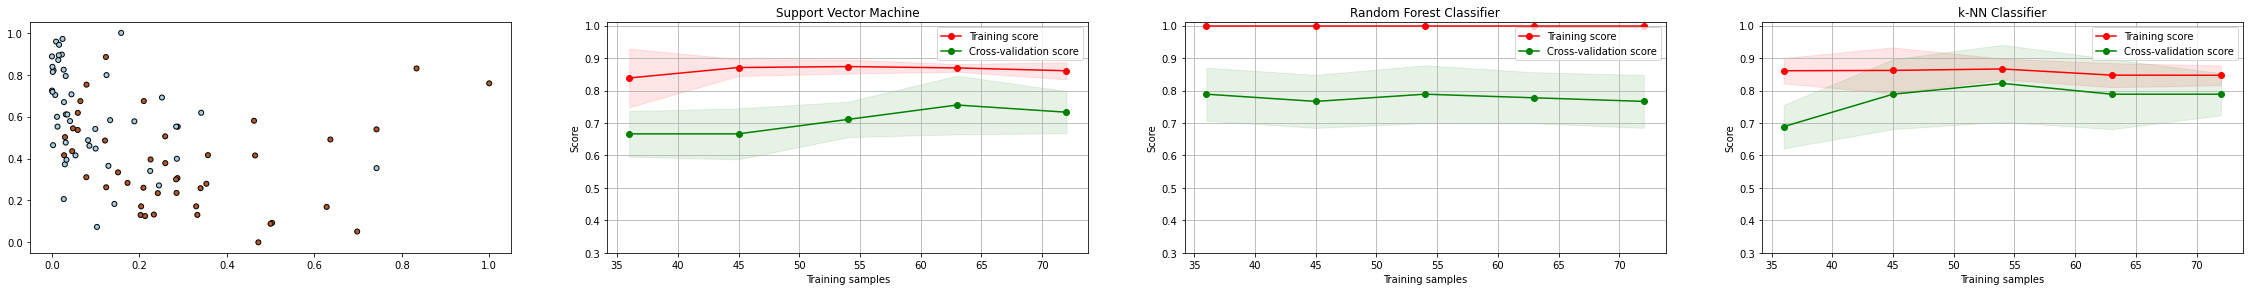

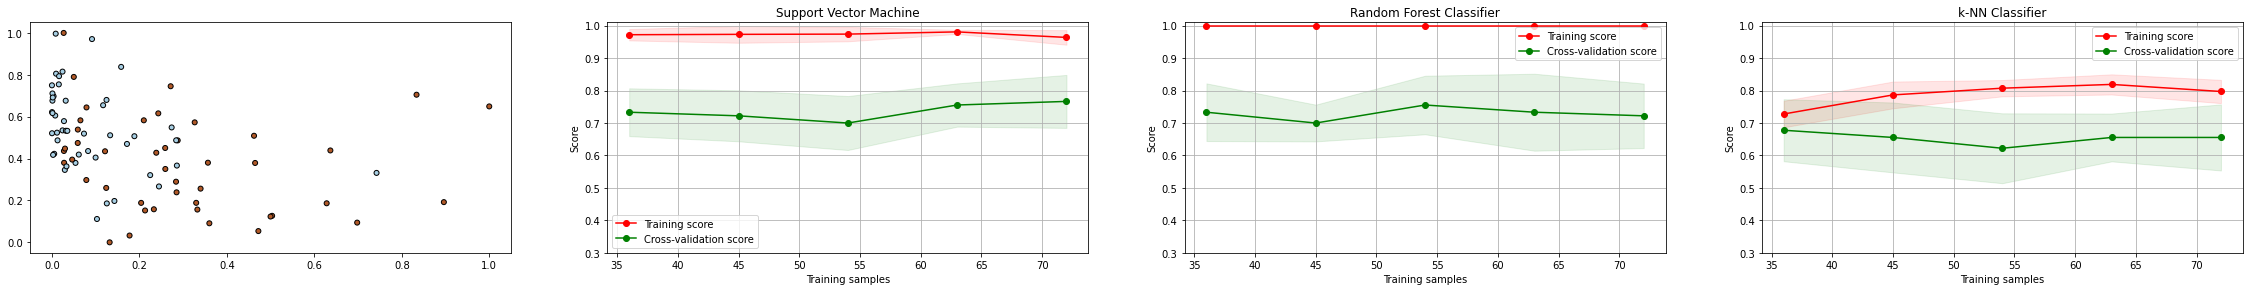

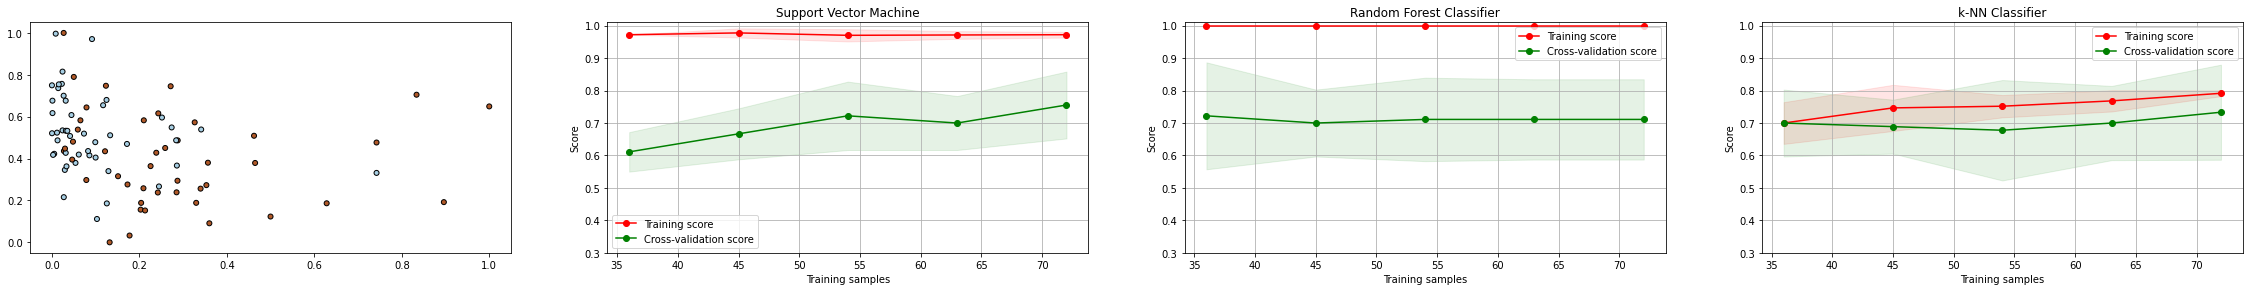

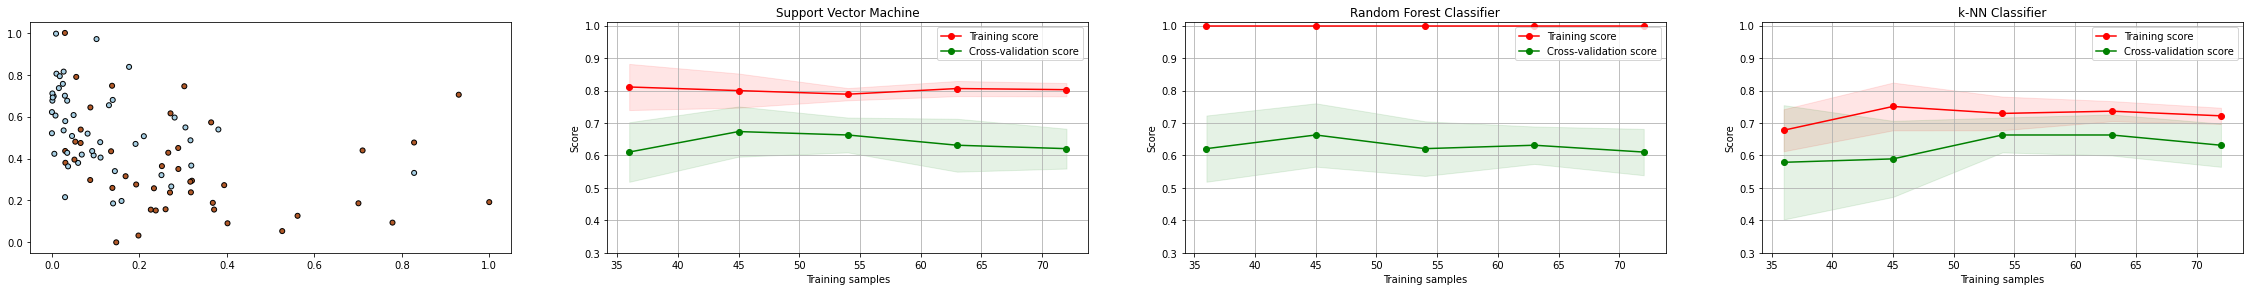

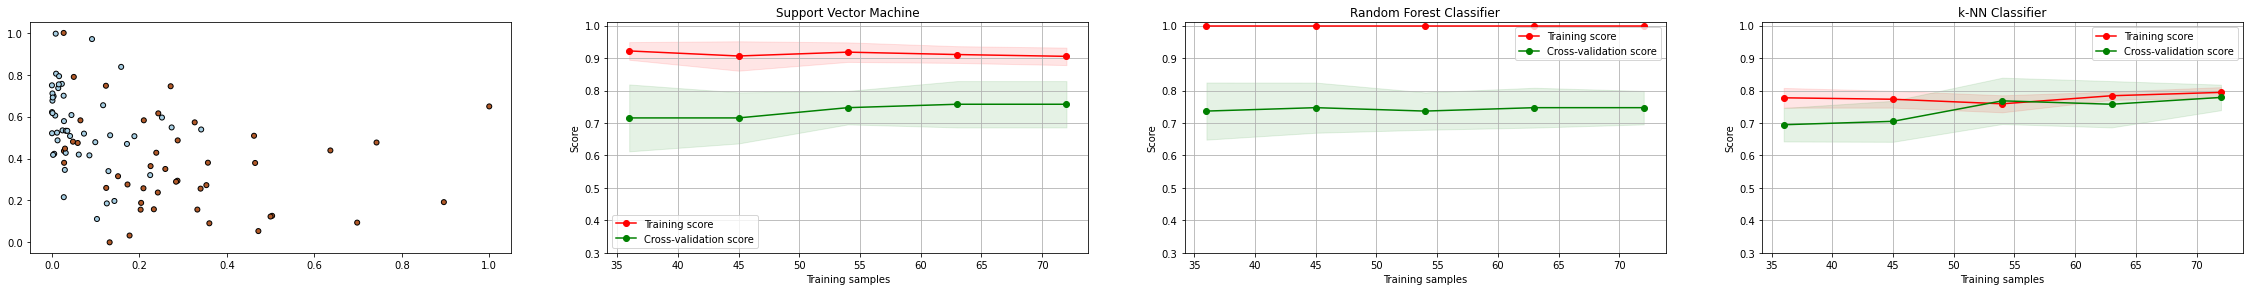

In [0]:
N = 5

skf = StratifiedKFold(n_splits=N)
for train_index, test_index in skf.split(data_without_label, y):
  X_train_no_label = data_without_label.iloc[train_index,:]
  X_test_no_label = data_without_label.iloc[test_index,:]
  y_train = y[train_index]
  x_train,x_val,y_train_2, y_val = train_test_split(X_train_no_label,y_train, test_size=0.2, train_size=0.8, random_state=0, stratify=y_train)
  y_train = y[train_index]
  y_test= y[test_index]

  Xtr_r, Xte_r, Xtr_r_array, Xte_r_array = scaled_data(X_train_no_label,X_test_no_label)
  Xtr_pca, Xte_pca = pca(Xtr_r, Xte_r, y_train, y_test)

  df_lasso_2_train, df_lasso_2_test = lasso2_featureselection(Xtr_r, y_train, Xte_r, y_test)
  df_univariate_train, df_univariate_test = univariate_featureselection(Xtr_r, y_train, Xte_r, y_test)

  clf_svm, train_score_svm, test_score_svm, auc_SVM, F1_SVM, precision_SVM, recall_SVM, acctr_SVM, accte_SVM = svm_classifier(Xtr_pca, Xte_pca, y_train, y_test, auc_SVM, F1_SVM, precision_SVM, recall_SVM, acctr_SVM, accte_SVM)
  rfc, train_score_rfc, test_score_rfc, auc_RF, F1_RF, precision_RF, recall_RF, acctr_RF, accte_RF = randomforest_classifier(Xtr_pca, Xte_pca, y_train, y_test, auc_RF, F1_RF, precision_RF, recall_RF, acctr_RF, accte_RF)
  clf_knn, train_score_knn, test_score_knn, auc_kNN, F1_kNN, precision_kNN, recall_kNN, acctr_kNN, accte_kNN = knn_classifier(Xtr_pca, Xte_pca, y_train, y_test, auc_kNN, F1_kNN, precision_kNN, recall_kNN, acctr_kNN, accte_kNN)

  plt = learn_cv(Xtr_r_array, y_train, clf_svm, clf_knn, rfc)


# Printing scores

In [0]:
# Creating df with SVM scores
results_SVM_df = pd.DataFrame({'AUC': auc_SVM, 'Recall': recall_SVM, 'Accuracy train': acctr_SVM, 'Accuracy test': accte_SVM})

av_SVM = results_SVM_df.mean(axis=0)
std_SVM = results_SVM_df.std(axis=0)
results_SVM_df.loc[len(results_SVM_df)] = av_SVM

for col in results_SVM_df.columns:
  results_SVM_df[col] = results_SVM_df[col].round(2)

av_CI_SVM = []
for i in range(4):
  av_CI_SVM.append(str(round(av_SVM[i],2))+' +/- '+str(round(std_SVM[i]*(1.96/np.sqrt(N)),2)))

results_SVM_df.loc[len(results_SVM_df)] = av_CI_SVM

new_index = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5', 5: 'average'}
results_SVM_df.rename(index = new_index, inplace=True)
print(results_SVM_df)

# Creating df with RF scores
results_RF_df = pd.DataFrame({'AUC': auc_RF, 'Recall': recall_RF, 'Accuracy train': acctr_RF, 'Accuracy test': accte_RF})

av_RF = results_RF_df.mean(axis=0)
std_RF = results_RF_df.std(axis=0)
results_RF_df.loc[len(results_RF_df)] = av_RF

for col in results_RF_df.columns:
  results_RF_df[col] = results_RF_df[col].round(2)

av_CI_RF = []
for i in range(4):
  av_CI_RF.append(str(round(av_RF[i],2))+' +/- '+str(round(std_RF[i]*(1.96/np.sqrt(N)),2)))

results_RF_df.loc[len(results_RF_df)] = av_CI_RF

results_RF_df.rename(index = new_index, inplace=True)
print(results_RF_df)

# Creating df with kNN scores
results_kNN_df = pd.DataFrame({'AUC': auc_kNN, 'Recall': recall_kNN, 'Accuracy train': acctr_kNN, 'Accuracy test': accte_kNN})
av_kNN = results_kNN_df.mean(axis=0)
std_kNN = results_kNN_df.std(axis=0)
results_kNN_df.loc[len(results_kNN_df)] = av_kNN

for col in results_kNN_df.columns:
  results_kNN_df[col] = results_kNN_df[col].round(2)

av_CI_kNN = []
for i in range(4):
  av_CI_kNN.append(str(round(av_kNN[i],2))+' +/- '+str(round(std_kNN[i]*(1.96/np.sqrt(N)),2)))

results_kNN_df.loc[len(results_kNN_df)] = av_CI_kNN

results_kNN_df.rename(index = new_index, inplace=True)
print(results_kNN_df)

# Create df with average scores
av_df_draft = pd.DataFrame({'SVM': av_SVM})
av_df = av_df_draft.transpose()
av_df.loc[len(av_df)] = av_RF
av_df.loc[len(av_df)] = av_kNN

index_av = {1: 'RF', 2: 'k-NN'}
av_df.rename(index = index_av, inplace=True)

for col in av_df.columns:
  av_df[col] = av_df[col].round(2)

print('\n\n DF with average scores per classifier: \n')
print(av_df)

# Create df with average scores +/- CI
CI_df_draft = pd.DataFrame({'SVM': av_CI_SVM})
CI_df = CI_df_draft.transpose()
CI_df.loc[len(CI_df)] = av_CI_RF
CI_df.loc[len(CI_df)] = av_CI_kNN

index_av = {1: 'RF', 2: 'k-NN'}
CI_df.rename(index = index_av, inplace=True)
CI_df.rename(columns = {0: 'AUC', 1: 'Recall', 2: 'Accuracy train', 3: 'Accuracy test'}, inplace=True)

# for col in CI_df.columns:
#   CI_df[col] = CI_df[col].round(2)

print('\n\n DF with average scores per classifier with CI: \n')
print(CI_df)


                  AUC         Recall Accuracy train Accuracy test
1                0.71           0.64           0.92          0.65
2                0.91              1           0.93          0.87
3                0.91           0.91           0.94          0.74
4                0.94           0.82           0.82          0.86
5                0.74           0.82           0.96          0.64
average          0.84           0.84           0.92          0.75
6        0.84 +/- 0.1  0.84 +/- 0.12  0.92 +/- 0.05  0.75 +/- 0.1
                  AUC         Recall Accuracy train  Accuracy test
1                0.72           0.64              1           0.61
2                0.86           0.91              1           0.74
3                0.96              1              1           0.78
4                0.94           0.82              1           0.82
5                0.74           0.73              1           0.64
average          0.84           0.82              1           0.72
6  